<a href="https://colab.research.google.com/github/CorsiDanilo/big-data-computing-project/blob/main/BDC_Project_Bitcoin_price_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin price forecasting with PySpark
## Big Data Computing final project - A.Y. 2022 - 2023
Prof. Gabriele Tolomei

MSc in Computer Science

La Sapienza, University of Rome

### Author
Corsi Danilo - corsi.1742375@studenti.uniroma1.it



### Introduction

The cryptocurrency Bitcoin has attracted the attention of many people in recent years. However, it's
price fluctuation can be extremely unpredictable, which makes it difficult to predict when the right
time to buy or sell this digital currency will be. In this context, forecasting Bitcoin prices can be a
competitive advantage for investors and traders, as it could allow them to make informed decisions
on the right time to enter or exit the market. In this project, I will analyze some machine learning
techniques to understand, through the processing of historical data, how accurately the price of Bitcoin
can be predicted and whether this can provide added value to cryptocurrency investors and traders.
### Dataset
I chose to use the following dataset from Kaggle Bitcoin Historical Dataset, more specifically those
containing minute-by-minute updates of the Bitcoin price from 2017 to 2021 (period for which there
were moments of high volatility but also a lot of price lateralisation). The columns (features) contained
in it, in addition to the timestamp of each transaction, are the opening, closing, highest and lowest
price and the corresponding trading volume in Bitcoin and Dollars.
### Methods (TODO: da scegliere per bene)
The methods I will test will be Linear Regression (simple and multiple) and Random Forest. Further
comparisons with other classification models are planned in the course of development. Moreover, I
would also like to try to understand what the differences are between these methods and the imple-
mentation of a state-of-the-art neural network such as Long-Short Term Memory.
### Evaluation framework (TODO: vedi quali usare in base ai paper/esempi e ai modelli utilizzati)
As evaluation framework I will use R-square (R²), Mean Square Error (MSE) and Mean Absolute
Error (MAE) to get a complete picture of the performance of the various models.

# **Spark + Google Colab Setup**

## **0.** Global Constants


In [1]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/drive"
GDRIVE_DATASET_DIR = GDRIVE_DIR + "/MyDrive/Computer_Science/BDC/project/datasets"

GDRIVE_DATASET = GDRIVE_DATASET_DIR + "/BTC-2017_2021.csv"

RANDOM_SEED = 42 # for reproducibility

## **1.** Install PySpark and related dependencies





In [2]:
!pip install pyspark
# Alternatively, if you want to install a specific version of pyspark:
#!pip install pyspark==3.2.1
!pip install -U -q PyDrive # To use files that are stored in Google Drive directly (e.g., without downloading them from an external URL)
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=7d6bc35751aa9fdd49d52db085644fe95a90c04a5881eb3db77a0567bb2d84bb
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 36.5 MB of archives.
After this operatio

## **2.** Import useful Python packages

In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from itertools import cycle

import plotly.express as px

from pyspark.sql import functions as F

## **3.** Create Spark context

In [4]:
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("BitcoinPriceForecasting").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

## **4.** Create <code>ngrok</code> tunnel to check the Spark UI

In [5]:
# Install ngrok
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=3a28aaf5c0044b396c749c14af7610b052918cd310d2eb22b061b75f7cb5c493
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok


In [6]:
# Saving authtoken 
!ngrok authtoken 2PKOO1E6Ghw65dpEG4QNSVzu9PY_GufsrTiussGmBxF664RD 

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [7]:
from pyngrok import ngrok

# Open a ngrok tunnel on the port 4050 where Spark is running
port = '4050'
public_url = ngrok.connect(port).public_url

In [8]:
print("To access the Spark Web UI console, please click on the following link to the ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

To access the Spark Web UI console, please click on the following link to the ngrok tunnel "https://af45-35-231-96-29.ngrok-free.app" -> "http://127.0.0.1:4050"


## **5.** Link Colab to our Google Drive

In [9]:
# Point Colaboratory to our Google Drive

from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


## **6.** Check everything is ok

In [10]:
spark

In [11]:
sc._conf.getAll()

[('spark.app.submitTime', '1685178856878'),
 ('spark.driver.port', '36423'),
 ('spark.driver.memory', '45G'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.app.id', 'local-1685178860580'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.app.name', 'BitcoinPriceForecasting'),
 ('spark.app.startTime', '1685178857197'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.c

# **Dataset, processing and feature extraction**

In this section we are going to explore the dataset, to clean it from null values, and to determine which features are relevant and which are not.

## **1.** Data cleaning

First, we import the dataset from Google Drive.

In [12]:
df = spark.read.load(GDRIVE_DATASET, 
                         format="csv", 
                         sep=",", 
                         inferSchema="true", 
                         header="true"
                         )

Check the shape of the loaded dataset, i.e.,

In [ ]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(df.count(), len(df.columns)))

The shape of the dataset is 2675301 rows by 9 columns


Print out the schema of the loaded dataset.

In [ ]:
df.printSchema()
df.show(5)	

# showing the last 5 rows
from pyspark.sql.functions import desc
from pyspark.sql.functions import monotonically_increasing_id
df.withColumn("index", monotonically_increasing_id()).orderBy(desc("index")).drop("index").show(5)	

root
 |-- unix: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- symbol: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- Volume BTC: double (nullable = true)
 |-- Volume USD: double (nullable = true)

+----------+-------------------+-------+--------+--------+--------+--------+----------+----------------+
|      unix|               date| symbol|    open|    high|     low|   close|Volume BTC|      Volume USD|
+----------+-------------------+-------+--------+--------+--------+--------+----------+----------------+
|1514764740|2017-12-31 23:59:00|BTC/USD|13913.28|13913.28|13867.18| 13880.0|0.59174759|    8213.4565492|
|1514764680|2017-12-31 23:58:00|BTC/USD|13913.26|13953.83|13884.69|13953.77|1.39878396|19518.3096575292|
|1514764620|2017-12-31 23:57:00|BTC/USD|13908.73|13913.26|13874.99|13913.26|0.77501206|10782.9442939156|
|1514764560|2017-12-31

We can delete the "symbol" and "unix" column since we are not gonna use it and changing the name of "Volume BTC" and "Volume USD".


In [13]:
df = df.withColumnRenamed("Volume BTC","volume_btc") \
    .withColumnRenamed("Volume USD","volume_usd") \
    .drop("symbol") \
    .drop("unix")

df.printSchema()
df.show(5)	

root
 |-- date: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume_btc: double (nullable = true)
 |-- volume_usd: double (nullable = true)

+-------------------+--------+--------+--------+--------+----------+----------------+
|               date|    open|    high|     low|   close|volume_btc|      volume_usd|
+-------------------+--------+--------+--------+--------+----------+----------------+
|2017-12-31 23:59:00|13913.28|13913.28|13867.18| 13880.0|0.59174759|    8213.4565492|
|2017-12-31 23:58:00|13913.26|13953.83|13884.69|13953.77|1.39878396|19518.3096575292|
|2017-12-31 23:57:00|13908.73|13913.26|13874.99|13913.26|0.77501206|10782.9442939156|
|2017-12-31 23:56:00| 13827.0|13908.69| 13827.0|13859.58|0.66645895|  9236.841134241|
|2017-12-31 23:55:00|13825.05|13825.05|13825.05|13825.05| 0.0655014|    905.56013007|
+-------------------+--------+--------+

Here, we can check how many Nan values we have in the dataset.

In [ ]:
df.select(*[
    (
        F.count(F.when((F.isnan(c) | F.col(c).isNull()), c)) if t not in ("timestamp", "date")
        else F.count(F.when(F.col(c).isNull(), c))
    ).alias(c)
    for c, t in df.dtypes if c in df.columns
]).show()

+----+----+----+---+-----+----------+----------+
|date|open|high|low|close|volume_btc|volume_usd|
+----+----+----+---+-----+----------+----------+
|   0|   0|   0|  0|    0|         0|         0|
+----+----+----+---+-----+----------+----------+



In [14]:
# computing the weighted price
df = df.withColumn('weighted_price', col('volume_usd') / col('volume_btc'))

We also reduce the columns in the DataFrame to two decimal places except for the volume in bitcoin.

In [15]:
df = df.withColumn("open", round(df["open"], 2)) \
                    .withColumn("close", round(df["close"], 2)) \
                    .withColumn("high", round(df["high"], 2)) \
                    .withColumn("low", round(df["low"], 2)) \
                    .withColumn("volume_usd", round(df["volume_usd"], 2)) \
                    .withColumn("weighted_price", round(df["weighted_price"], 2)
                  )
df.show(5)	                

+-------------------+--------+--------+--------+--------+----------+----------+--------------+
|               date|    open|    high|     low|   close|volume_btc|volume_usd|weighted_price|
+-------------------+--------+--------+--------+--------+----------+----------+--------------+
|2017-12-31 23:59:00|13913.28|13913.28|13867.18| 13880.0|0.59174759|   8213.46|       13880.0|
|2017-12-31 23:58:00|13913.26|13953.83|13884.69|13953.77|1.39878396|  19518.31|      13953.77|
|2017-12-31 23:57:00|13908.73|13913.26|13874.99|13913.26|0.77501206|  10782.94|      13913.26|
|2017-12-31 23:56:00| 13827.0|13908.69| 13827.0|13859.58|0.66645895|   9236.84|      13859.58|
|2017-12-31 23:55:00|13825.05|13825.05|13825.05|13825.05| 0.0655014|    905.56|      13825.05|
+-------------------+--------+--------+--------+--------+----------+----------+--------------+
only showing top 5 rows



## **2.** Exploring the data
Now, before building a model to predict the Bitcoin price, let's try a have a better visualization of the data.

Daily analysis of the price from 2017 to 2021

In [18]:
# Calculation of the average price and volume for each day
daily_df = df.withColumn("date", date_format(df.date, "yyyy-MM-dd")).groupBy("date").agg(
    avg("open").alias("daily_open"),
    avg("close").alias("daily_close"),
    avg("high").alias("daily_high"),
    avg("low").alias("daily_low"),
    avg("volume_btc").alias("daily_volume_btc"),
    avg("volume_usd").alias("daily_volume_usd"),
    avg("weighted_price").alias("daily_weighted_price")
).sort("date")

# Reduce the columns in the DataFrame to two decimal places
daily_df = daily_df.withColumn("daily_open", round(daily_df["daily_open"], 2)) \
                    .withColumn("daily_close", round(daily_df["daily_close"], 2)) \
                    .withColumn("daily_high", round(daily_df["daily_high"], 2)) \
                    .withColumn("daily_low", round(daily_df["daily_low"], 2)) \
                    .withColumn("daily_volume_usd", round(daily_df["daily_volume_usd"], 2)) \
                    .withColumn("daily_weighted_price", round(daily_df["daily_weighted_price"], 2)
                    )
                    
print("The shape of the dataset is {:d} rows by {:d} columns".format(daily_df.count(), len(daily_df.columns)))            
daily_df.show(5)	    

The shape of the dataset is 1860 rows by 8 columns
+----------+----------+-----------+----------+---------+------------------+----------------+--------------------+
|      date|daily_open|daily_close|daily_high|daily_low|  daily_volume_btc|daily_volume_usd|daily_weighted_price|
+----------+----------+-----------+----------+---------+------------------+----------------+--------------------+
|2017-01-01|    977.26|     977.28|    977.39|   977.13| 4.760662479909663|         4701.83|              981.66|
|2017-01-02|   1012.27|    1012.27|   1012.52|  1011.99| 5.671792382069449|         5747.24|             1013.26|
|2017-01-03|    1020.0|    1020.04|   1020.23|  1019.79| 6.312262517562504|         6442.18|             1020.04|
|2017-01-04|   1076.56|    1076.55|   1077.27|  1075.57| 14.97392845275002|        16303.13|              1079.6|
|2017-01-05|   1043.61|    1043.55|   1044.91|  1042.09|25.013097999937482|        25132.51|             1039.79|
+----------+----------+-----------+--

In [21]:
# convert the daily_df from PySpark to Pandas to be able to plot it more easly                    
daily_df_pandas = daily_df.toPandas()

# delete daily_df (PySpark) since we are not gonne use it anymore
del daily_df

import gc

gc.collect()

51

In [23]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# We use Plotly to create the plots https://plot.ly/python/
trace1 = go.Scatter(
    x = daily_df_pandas['date'],
    y = daily_df_pandas['daily_open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = daily_df_pandas['date'],
    y = daily_df_pandas['daily_close'].astype(float),
    mode = 'lines',
    name = 'Close'
)
trace3 = go.Scatter(
    x = daily_df_pandas['date'],
    y = daily_df_pandas['daily_high'].astype(float),
    mode = 'lines',
    name = 'High'
)
trace4 = go.Scatter(
    x = daily_df_pandas['date'],
    y = daily_df_pandas['daily_low'].astype(float),
    mode = 'lines',
    name = 'Low'
)

trace5 = go.Scatter(
    x = daily_df_pandas['date'],
    y = daily_df_pandas['daily_weighted_price'].astype(float),
    mode = 'lines',
    name = 'Weighted Price'
)

layout = dict(
    title='Historical Bitcoin Prices (2017 - 2021) with the Slider ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2, trace3, trace4, trace5]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

Lets visualize Historical Bitcoin Market Volume (2017 - 2021)

In [39]:
trace1 = go.Scatter(
    x = daily_df_pandas['date'],
    y = daily_df_pandas['daily_volume_usd'].astype(float),
    mode = 'lines',
    name = 'Bitcoin Price (Open)'
)

layout = dict(
    title='Historical Bitcoin Volume (USD) (2017 - 2021) with the slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

As we can see we have some missing values between Nov 23 2020 and Dec 20 2020 
(TODO: da sistemare)

In [67]:
start_date = '2020-11-23 00:00:00'
end_date = '2020-12-20 23:59:59'

df_filtrato = df.filter((col("date") >= start_date) & (col("date") <= end_date))

ultima_occ = df_filtrato.select(min("date")).first()[0]
prima_occ = df_filtrato.select(max("date")).first()[0]

print(str(ultima_occ) + " " + str(prima_occ))

2020-11-23 00:00:00 2020-12-20 23:59:00


In [27]:
#BTC Volume vs Price USD visualization
trace = go.Scattergl(
    y = daily_df_pandas['daily_volume_btc'].astype(float),
    x = daily_df_pandas['daily_weighted_price'].astype(float),
    mode = 'markers',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    )
)
layout = go.Layout(
    title='BTC Volume v/s USD',
    xaxis=dict(
        title='Weighted Price',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Volume BTC',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )))
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='compare_volume_btc_weighted_price')

## **4.** Feature Selection (TODO: da sistemare)
https://www.kaggle.com/code/debashis74017/time-series-forecasting-itcoin-price/notebook#%F0%9F%93%8A--2.-EDA-on-Bitcoin-Data-

📒 Important Terms to understand for Time Series Analysis
A Time-Series is a sequence of data points collected at different timestamps. These are essentially successive measurements collected from the same data source at the same time interval. Further, we can use these chronologically gathered readings to monitor trends and changes over time. The time-series models can be univariate or multivariate. The univariate time series models are implemented when the dependent variable is a single time series, like room temperature measurement from a single sensor. On the other hand, a multivariate time series model can be used when there are multiple dependent variables, i.e., the output depends on more than one series. An example for the multivariate time-series model could be modelling the GDP, inflation, and unemployment together as these variables are linked to each other.

📗 1. Stationary and Non-Stationary Time Series
Stationarity is a property of a time series. A stationary series is one where the values of the series is not a function of time. That is, the statistical properties of the series like mean, variance and autocorrelation are constant over time. Autocorrelation of the series is nothing but the correlation of the series with its previous values, more on this coming up. A stationary time series id devoid of seasonal effects as well.

📗 2. Trend
The trend shows a general direction of the time series data over a long period of time. A trend can be increasing(upward), decreasing(downward), or horizontal(stationary).

📗 3.Seasonality
The seasonality component exhibits a trend that repeats with respect to timing, direction, and magnitude. Some examples include an increase in water consumption in summer due to hot weather conditions.

📗 4. Cyclical Component
These are the trends with no set repetition over a particular period of time. A cycle refers to the period of ups and downs, booms and slums of a time series, mostly observed in business cycles. These cycles do not exhibit a seasonal variation but generally occur over a time period of 3 to 12 years depending on the nature of the time series.

📗 5. Irregular Variation
These are the fluctuations in the time series data which become evident when trend and cyclical variations are removed. These variations are unpredictable, erratic, and may or may not be random.

📗 6. ETS Decomposition
ETS Decomposition is used to separate different components of a time series. The term ETS stands for Error, Trend and Seasonality.

📗 7. Dependence
It refers to the association of two observations of the same variable at prior time periods.

📗 8. Differencing
Differencing is used to make the series stationary and to control the auto-correlations. There may be some cases in time series analyses where we do not require differencing and over-differenced series can produce wrong estimates.

📗 9. Specification
It may involve the testing of the linear or non-linear relationships of dependent variables by using time series models such as ARIMA models.

📗 10. ARIMA
ARIMA stands for Auto Regressive Integrated Moving Average.

The aim of this section is to remove the features that have less of an impact to the final result from the dataframe. This operation is called feature selection. Let's plot a correlation map to see how features are correlated among each other:

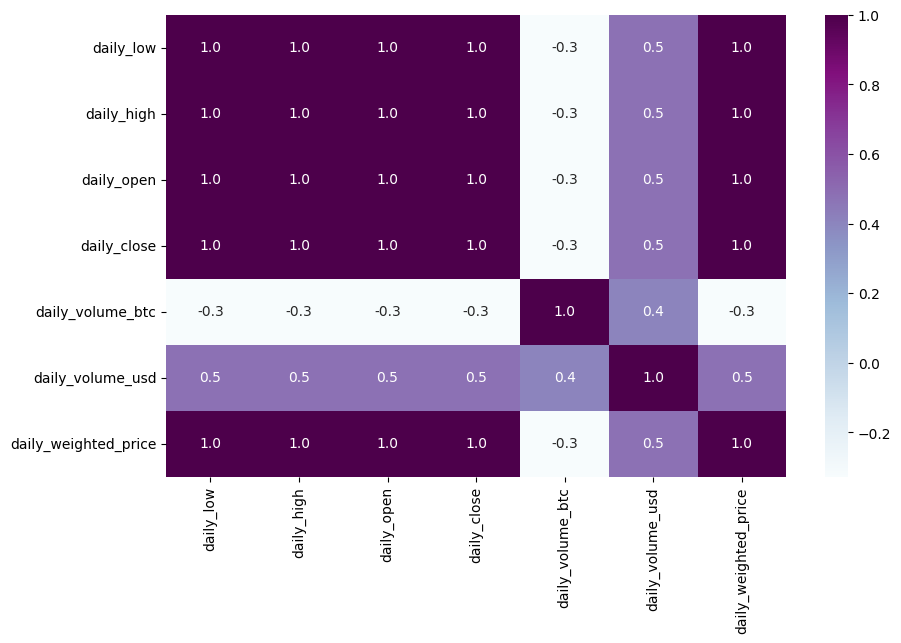

In [28]:
import seaborn as sns
# plotting correlation heatmap
plt.figure(figsize = (10, 6))
dataplot = sns.heatmap(daily_df_pandas[['daily_low','daily_high','daily_open','daily_close', 'daily_volume_btc', 'daily_volume_usd', 'daily_weighted_price']].corr(), cmap="BuPu", annot=True, 
                      fmt=".1f")
plt.show()

Here we can observe that, the high, low, open, close and weighted price are the almost correlate features, so for price forecasting, we can drop them from the origial dataset. Also we can drop volume_btc since we are not gonna use it. 

Selected Features
- Weighted Price
- USD Volume

In [29]:
df = df.drop("high") \
      .drop("low") \
      .drop("open") \
      .drop("close") \
      .drop("volume_btc") \
      .drop("volume_usd") # just for now :)

df.printSchema()
df.show(5)

root
 |-- date: timestamp (nullable = true)
 |-- weighted_price: double (nullable = true)

+-------------------+--------------+
|               date|weighted_price|
+-------------------+--------------+
|2017-12-31 23:59:00|       13880.0|
|2017-12-31 23:58:00|      13953.77|
|2017-12-31 23:57:00|      13913.26|
|2017-12-31 23:56:00|      13859.58|
|2017-12-31 23:55:00|      13825.05|
+-------------------+--------------+
only showing top 5 rows



## **3.** Model preparation (TODO: da sistemare)

First Step is Preparing Data for Training and Testing.
As we want to predict Close Price of the Bitcoin so we are just Considering Close aand Date. Since Bitcoin price has drastically flucated from 200 dollar in year 2014 to 15000 dollar in year 2018 to 3000 dollar in year 2019(theses values are apporx) so we will just consider 1 Year to avoid this type of flucation in the data.


### First model preparation
https://www.kaggle.com/code/someadityamandal/bitcoin-time-series-forecasting/notebook

Creating new dataframe of Bitcoin data containing only date and closing price

In [ ]:
# # Lets First Take all the Close Price 
# data['date'] = data['date'].dt.tz_localize(None)
# data = data.groupby([pd.Grouper(key='date', freq='H')]).first().reset_index()
# data = data.set_index('date')
# data = data[['close']]
# data['close'].fillna(method='ffill', inplace=True)

# print("Shape of close dataframe:", data.shape)

Shape of close dataframe: (45244, 1)


In [ ]:
# split data
split_date = '2021-07-20'
data_train = df.filter(col('date') <= split_date)
data_test = df.filter(col('date') > split_date)

In [ ]:
# Data preprocess

from pyspark.sql import SparkSession
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors

# Assume che tu abbia un DataFrame chiamato 'df' con le colonne 'data' e 'prezzo_chiusura'
# Seleziona le colonne 'data' e 'prezzo_chiusura' e convertile in un DenseVector
data = data_train.select('date', 'close').rdd.map(lambda x: (x[0], Vectors.dense(x[1])))

# Crea un DataFrame con le colonne 'data' e 'features' contenente il DenseVector
data = spark.createDataFrame(data, ['date', 'close'])

# Inizializza il MinMaxScaler
scaler = MinMaxScaler(inputCol='close', outputCol='normalized_close')

# Calcola i parametri di normalizzazione
scalerModel = scaler.fit(data)

# Applica la normalizzazione alle features
normalized_data = scalerModel.transform(data)

# Seleziona solo le colonne 'data' e 'normalized_features'
normalized_data = normalized_data.select('date', 'normalized_close')

# Mostra il dataset normalizzato
normalized_data.show()

# training_set = data_train.values
# training_set = np.reshape(training_set, (len(training_set), 1))

# from sklearn.preprocessing import MinMaxScaler

# sc = MinMaxScaler()
# training_set = sc.fit_transform(training_set)
# X_train = training_set[0:len(training_set)-1]
# y_train = training_set[1:len(training_set)]
# X_train = np.reshape(X_train, (len(X_train), 1, 1))

+-------------------+--------------------+
|               date|    normalized_close|
+-------------------+--------------------+
|2017-12-31 23:59:00|[0.20478117455027...|
|2017-12-31 23:58:00|[0.20593190225256...|
|2017-12-31 23:57:00|[0.20529999254374...|
|2017-12-31 23:56:00|[0.20446264588441...|
|2017-12-31 23:55:00|[0.20392401734218...|
|2017-12-31 23:54:00|[0.20437997194077...|
|2017-12-31 23:53:00|[0.2048459098080311]|
|2017-12-31 23:52:00|[0.2048299989735952]|
|2017-12-31 23:51:00|[0.2048591688367277]|
|2017-12-31 23:50:00|[0.2055186885229536]|
|2017-12-31 23:49:00|[0.20551962445439...|
|2017-12-31 23:48:00|[0.20575376330231...|
|2017-12-31 23:47:00|[0.20574222014792...|
|2017-12-31 23:46:00|[0.20492172025446...|
|2017-12-31 23:45:00|[0.20556049346049...|
|2017-12-31 23:44:00|[0.20495198203760...|
|2017-12-31 23:43:00|[0.20556111741478...|
|2017-12-31 23:42:00|[0.2060270552820383]|
|2017-12-31 23:41:00|[0.20649392908073...|
|2017-12-31 23:40:00|[0.20599180186456...|
+----------

TypeError: ignored

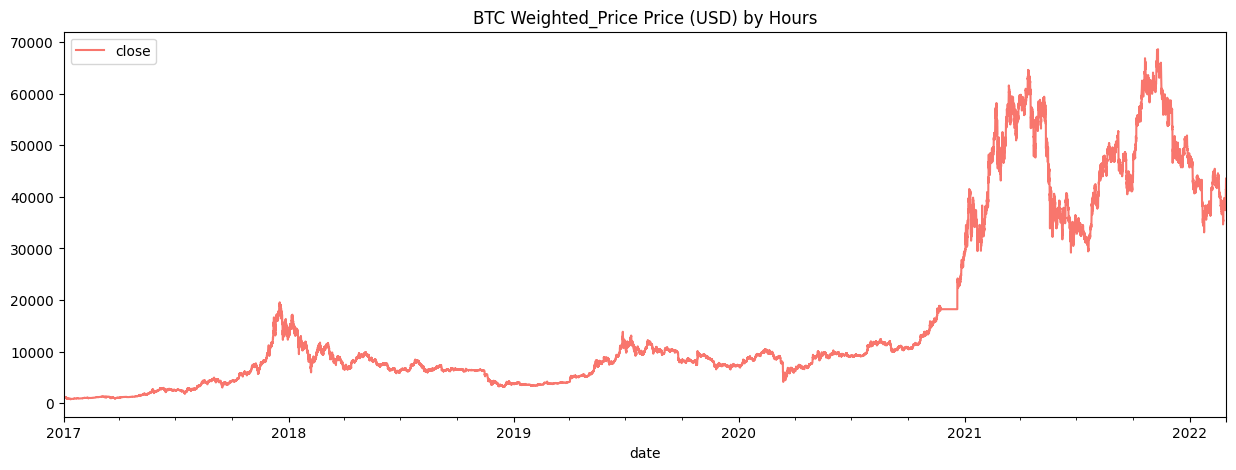

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

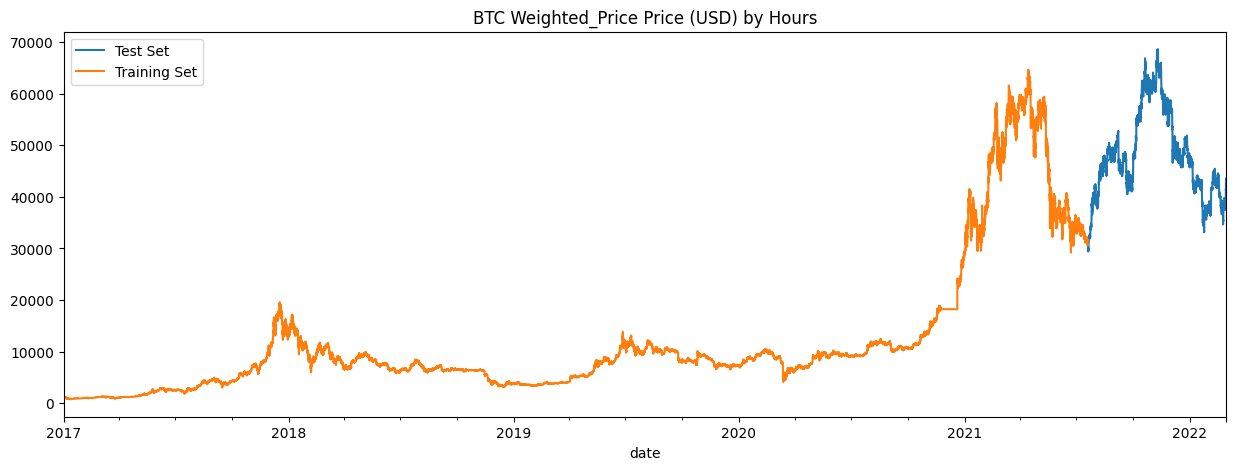

In [ ]:
_ = data_test \
    .rename(columns={'close': 'Test Set'}) \
    .join(data_train.rename(columns={'close': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

### Another model preparation
https://www.kaggle.com/code/meetnagadia/xgboost-bitcoin-price-prediction/notebook#6.-EDA--%F0%9F%93%8A-%F0%9F%93%88-%F0%9F%93%89

In [ ]:
close_df = df_pandas[['date','close']]
print("Shape of close dataframe:", close_df.shape)

In [ ]:
closedf = closedf[closedf['date'] > '2020-09-13']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

**Normalizing Data**

Normalization is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values or losing information.
MinMaxScaler. For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum. MinMaxScaler preserves the shape of the original distribution.

In [ ]:
# deleting date column and normalizing using MinMax Scaler
del close_df['date']

from sklearn.preprocessing import MinMaxScaler




Slicing data into Training set and Testing set

In [ ]:
# we keep the training set as 60% and 40% testing set
training_size=int(len(close_df)*0.60)
test_size=len(close_df)-training_size
train_data,test_data=close_df[0:training_size,:],close_df[training_size:len(close_df),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1605180, 1)
test_data:  (1070121, 1)


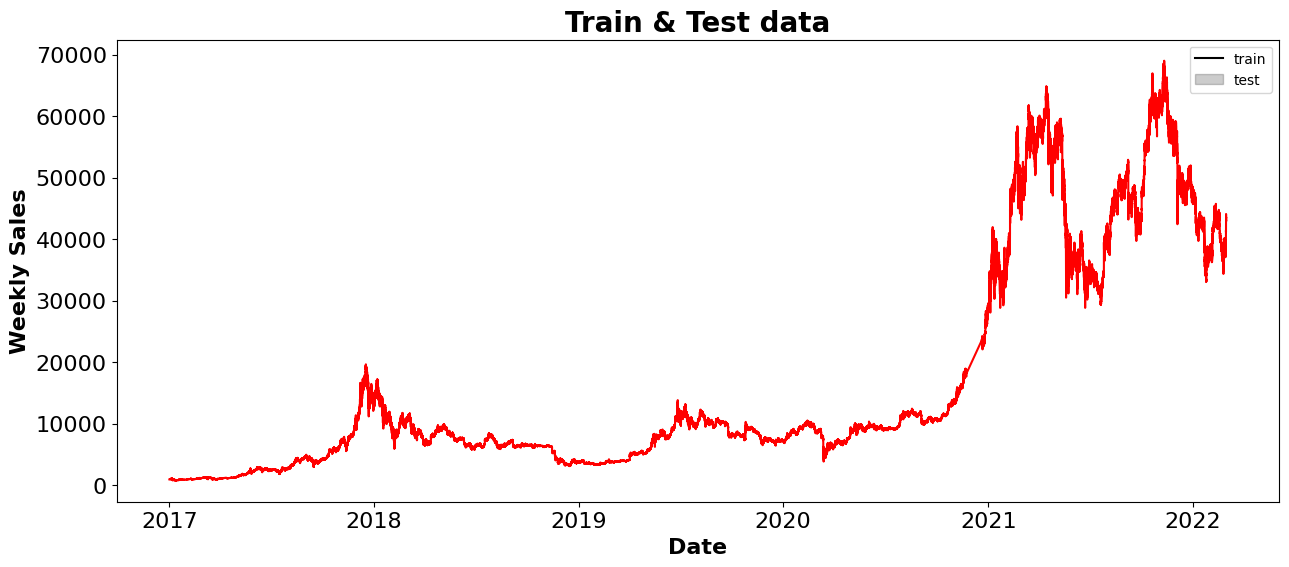

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = close_stock['date'][:241], y = close_stock['close'][:241], color = 'black')
sns.lineplot(x = close_stock['date'][241:], y = close_stock['close'][241:], color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

Now we Transform the Close price based on Time-series-analysis forecasting requirement , Here we will take 15


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1605164, 15)
y_train:  (1605164,)
X_test:  (1070105, 15)
y_test (1070105,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for time series analysis
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

# 4. Application of models

### **0.** LSTM (TODO: da sistemare)
In the first section, we use LSTM (Long short-term memory ). LSTM units are units of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network (or just LSTM). A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. Read more about LSTMs here.

Though LSTM is not ideal for forecasting turbulent market like Bitcoin but we still take a chance here.

In [ ]:
data['date'] = data['date'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='date', freq='H')]).first().reset_index()
data = data.set_index('date')
data = data[['close']]
data['close'].fillna(method='ffill', inplace=True)

For the train and test, we take '25-Jun-2018' as the split date. There was a considerable dip in Bitcoin prices between the June-July period 2018. If we check the historical prices the seasonal market started going up from this date after reaching the lowest, though the price reached much lower $5972 on June 29th 2018. After reaching the historic 20K mark on December 18th, there were several dips and market price was recorrected every time. Read more about Bitcoin dips.

In [ ]:
# split data
split_date = '20-Jul-2021'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

In [ ]:
# Data preprocess
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

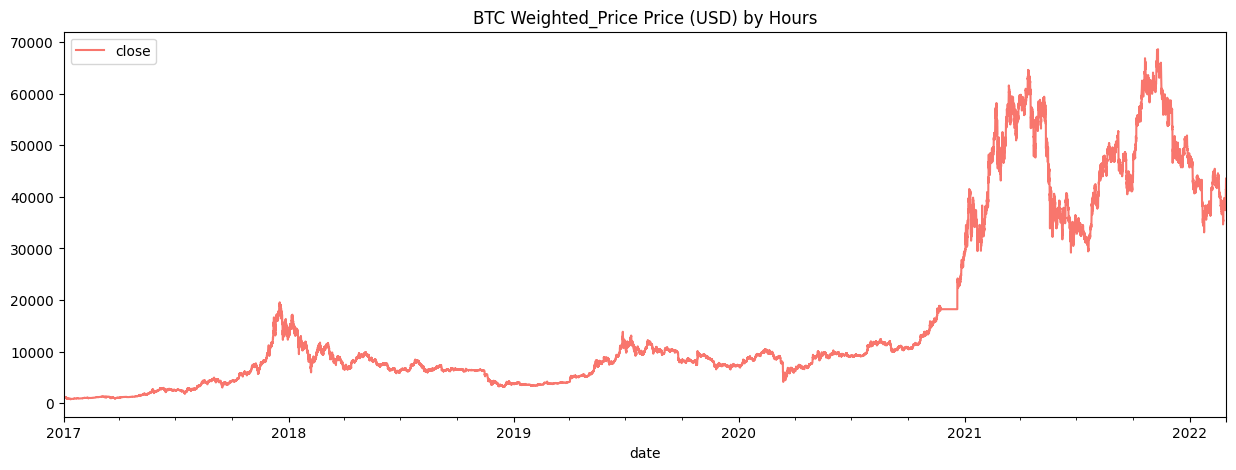

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

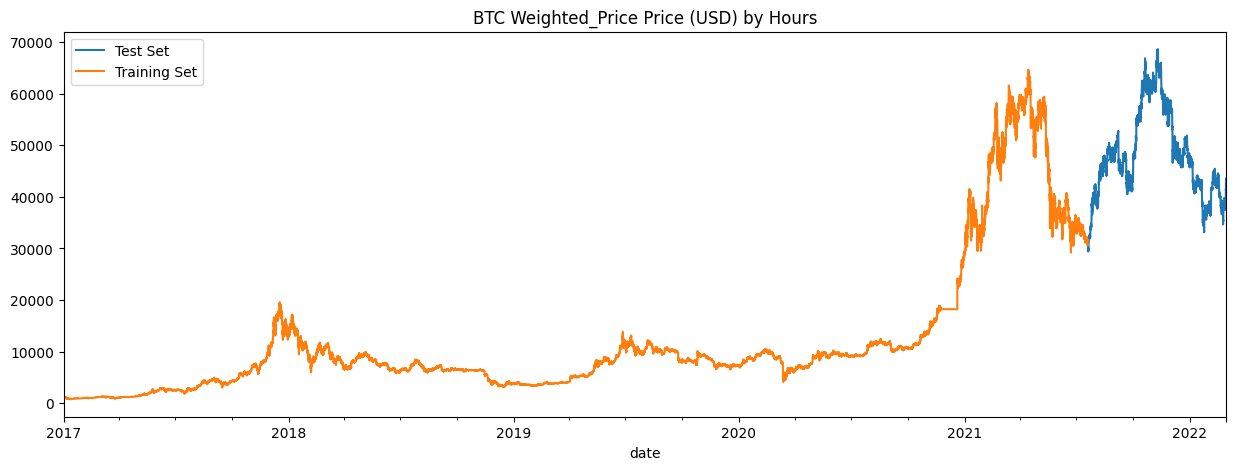

In [ ]:
_ = data_test \
    .rename(columns={'close': 'Test Set'}) \
    .join(data_train.rename(columns={'close': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

We will use a Vanilla LSTM here for forecasting. The model is trained on pre 25-Jun-2018 data.



In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
798/798 - 5s - loss: 0.0365 - 5s/epoch - 6ms/step
Epoch 2/100
798/798 - 4s - loss: 0.0102 - 4s/epoch - 5ms/step
Epoch 3/100
798/798 - 4s - loss: 0.0057 - 4s/epoch - 5ms/step
Epoch 4/100
798/798 - 3s - loss: 0.0040 - 3s/epoch - 4ms/step
Epoch 5/100
798/798 - 3s - loss: 0.0030 - 3s/epoch - 4ms/step
Epoch 6/100
798/798 - 3s - loss: 0.0024 - 3s/epoch - 4ms/step
Epoch 7/100
798/798 - 5s - loss: 0.0019 - 5s/epoch - 6ms/step
Epoch 8/100
798/798 - 3s - loss: 0.0016 - 3s/epoch - 4ms/step
Epoch 9/100
798/798 - 3s - loss: 0.0014 - 3s/epoch - 4ms/step
Epoch 10/100
798/798 - 3s - loss: 0.0012 - 3s/epoch - 4ms/step
Epoch 11/100
798/798 - 5s - loss: 0.0011 - 5s/epoch - 6ms/step
Epoch 12/100
798/798 - 3s - loss: 9.3623e-04 - 3s/epoch - 4ms/step
Epoch 13/100
798/798 - 3s - loss: 8.5249e-04 - 3s/epoch - 4ms/step
Epoch 14/100
798/798 - 3s - loss: 7.6311e-04 - 3s/epoch - 4ms/step
Epoch 15/100
798/798 - 4s - loss: 6.9920e-04 - 4s/epoch - 5ms/step
Epoch 16/100
798/798 - 4s - loss: 6.5857e-04 - 4

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

169/169 [==============================] - 1s 3ms/step


In [ ]:
data_test['close_prediction'] = predicted_BTC_price
data_all = pd.concat([data_test, data_train], sort=False)

In [ ]:
#saving the predicted values in a common data frame for future comparision
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'close_prediction': 'lstm'})
final_data = final_data[['date','close','lstm']]

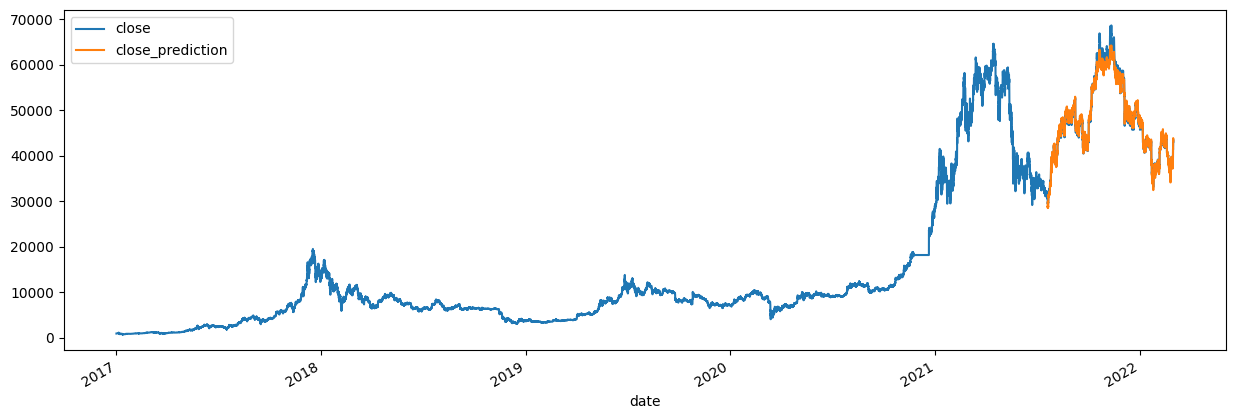

In [ ]:
_ = data_all[['close','close_prediction']].plot(figsize=(15, 5))


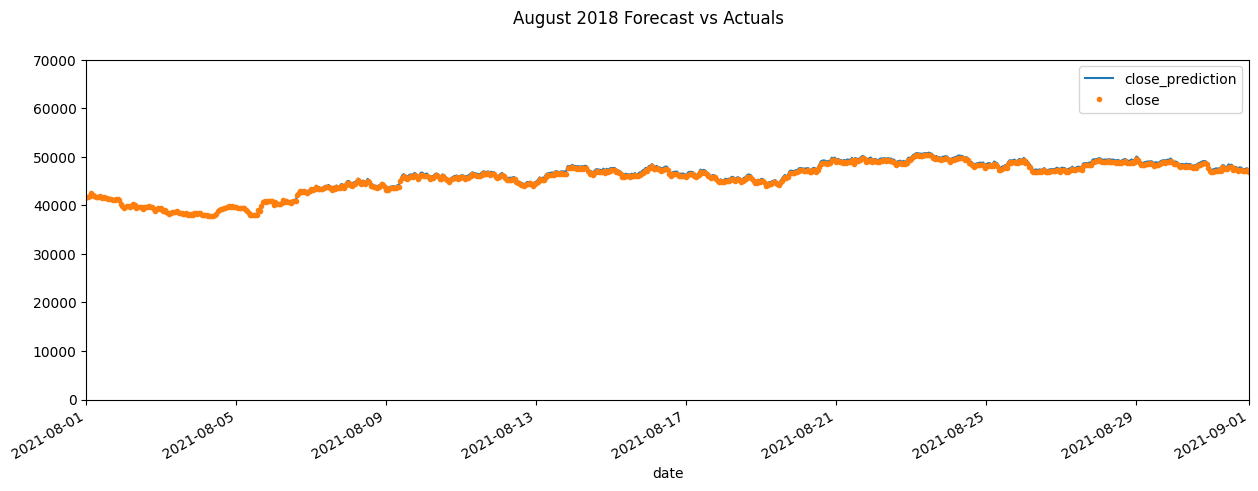

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['close_prediction','close']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2021', upper='09-01-2021')
ax.set_ylim(0, 70000)
plot = plt.suptitle('August 2018 Forecast vs Actuals')

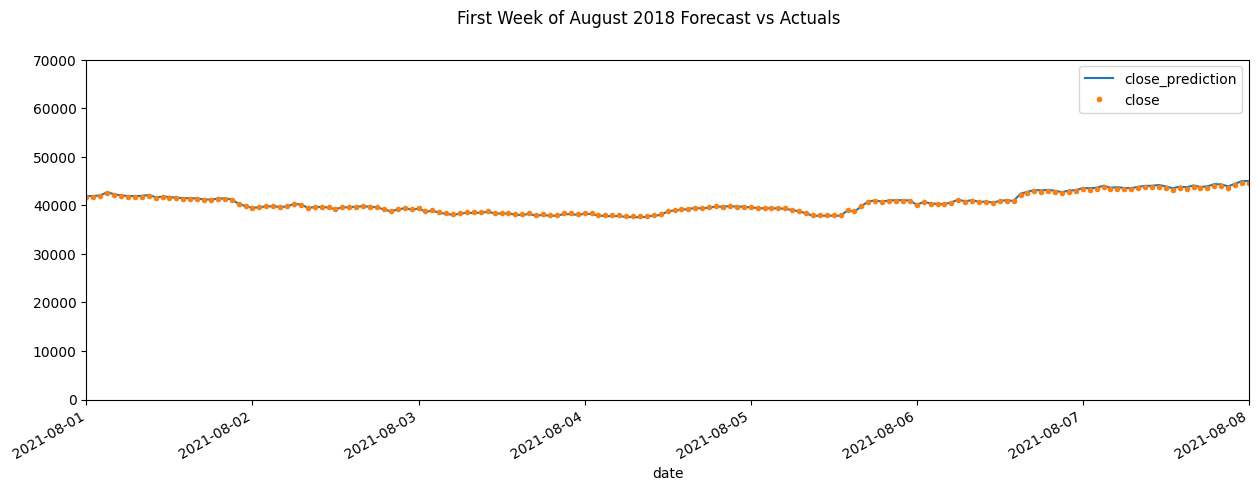

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['close_prediction','close']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2021', upper='08-08-2021')
ax.set_ylim(0, 70000)
plot = plt.suptitle('First Week of August 2018 Forecast vs Actuals')

In [ ]:
#calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_true=data_test['close'],
                   y_pred=data_test['close_prediction'])

769368.1511175948

In [ ]:
mean_absolute_error(y_true=data_test['close'],
                   y_pred=data_test['close_prediction'])

577.1765881204685

We can clearly see the entire model is over-fitted.



### **1.** XGBoost (TODO: spiegare perché non hai scelto Random Forest)

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. XGBoost is a powerful and versatile tool. Lets see, How well does XGBoost perform when used to predict future values of a time-series like Bitcoin prices ?

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [ ]:
# data['date'] = data['date'].dt.tz_localize(None)
# data = data.groupby([pd.Grouper(key='date', freq='H')]).first().reset_index()
# data = data.set_index('date')
# data = data[['close']]
# data['close'].fillna(method='ffill', inplace=True)

KeyError: ignored

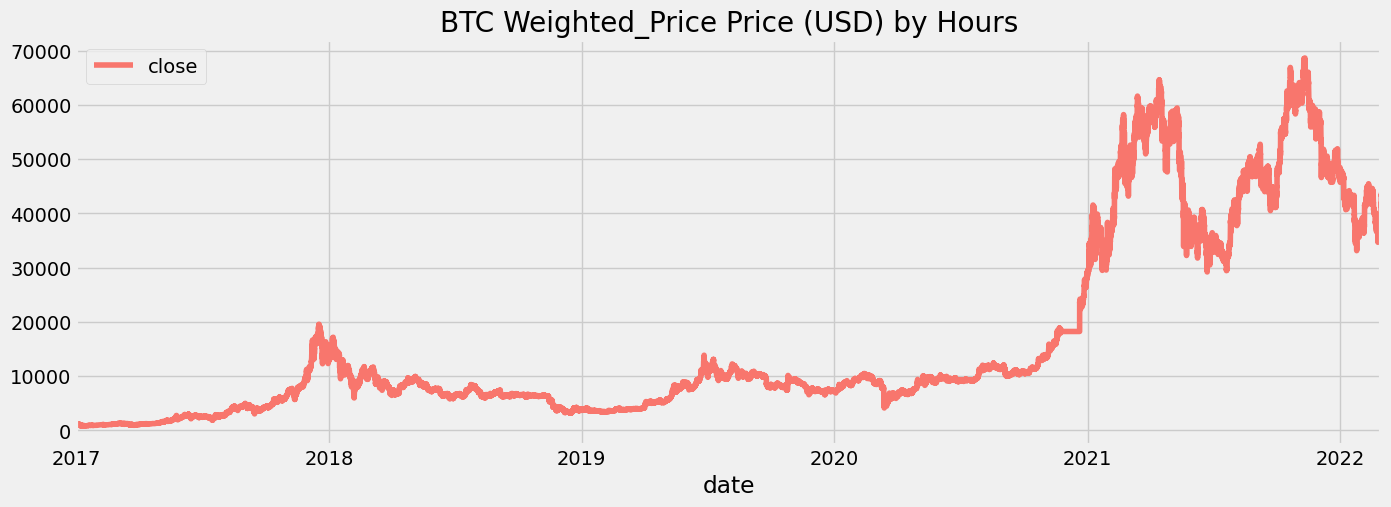

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

In [ ]:
split_date = '20-Jul-2021'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

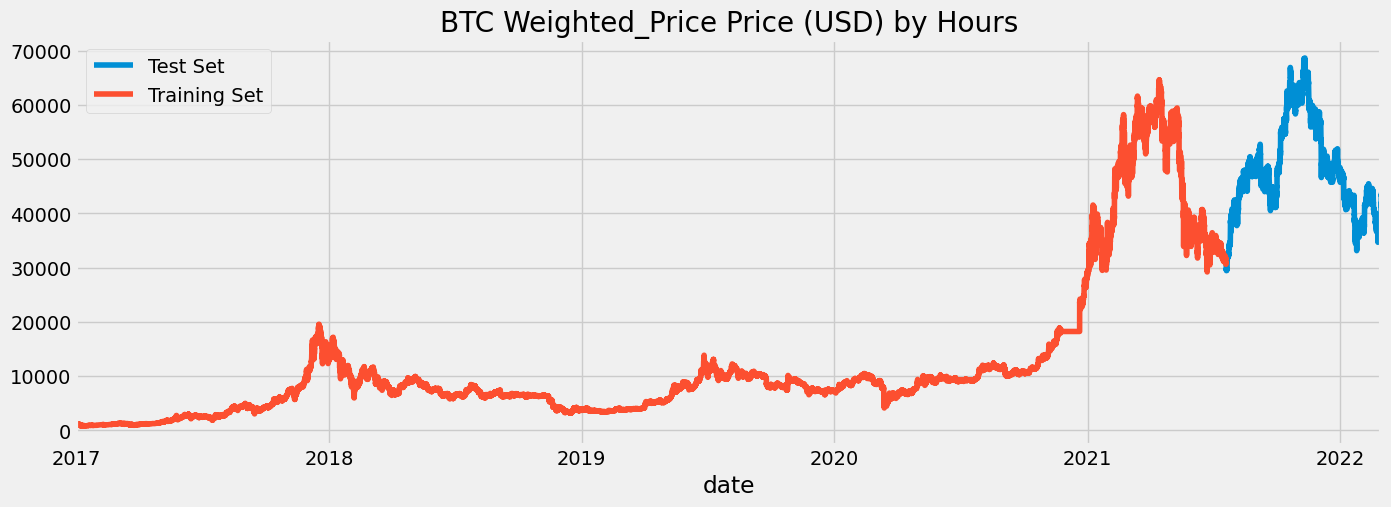

In [ ]:
_ = data_test \
    .rename(columns={'close': 'Test Set'}) \
    .join(data_train.rename(columns={'close': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(data_train, label='close')
X_test, y_test = create_features(data_test, label='close')

<ipython-input-55-568ff9107aea>:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.

<ipython-input-55-568ff9107aea>:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



Here we use a basic XGBRegressor model,

In [ ]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
model =  xgb.XGBRegressor(objective ='reg:squarederror',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBRegressor(alpha=10, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [ ]:
data_test['close_prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

In [ ]:
# # saving the predicted values in a common data frame for future comparision
# final_data = data_all
# final_data = final_data.reset_index()
# final_data = final_data.rename(columns={'close_rediction': 'xgboost'})
# final_data = final_data[['date','volume_usd_prediction','xgboost']]

ValueError: ignored

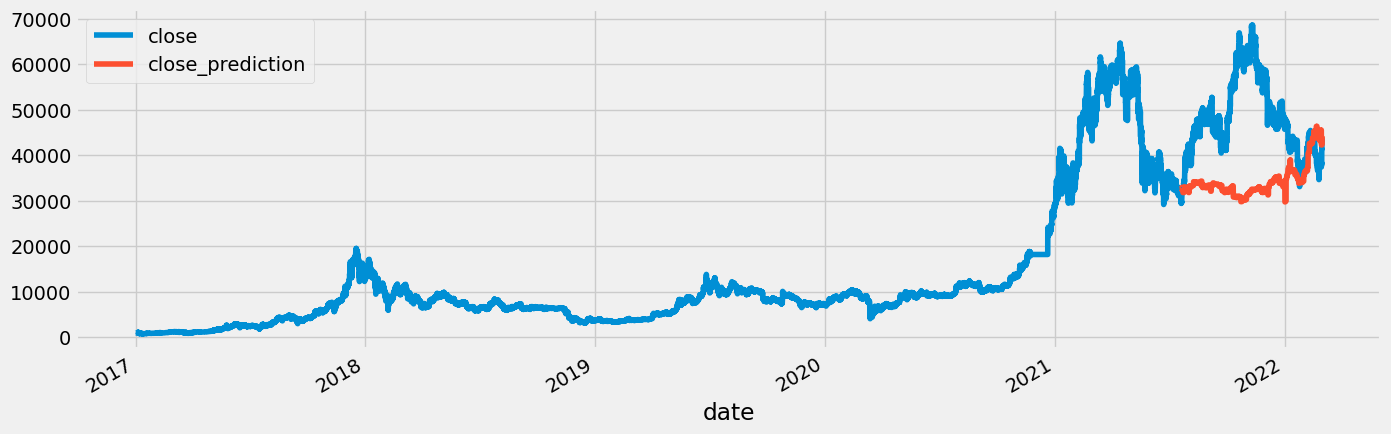

In [ ]:
_ = data_all[['close','close_prediction']].plot(figsize=(15, 5))

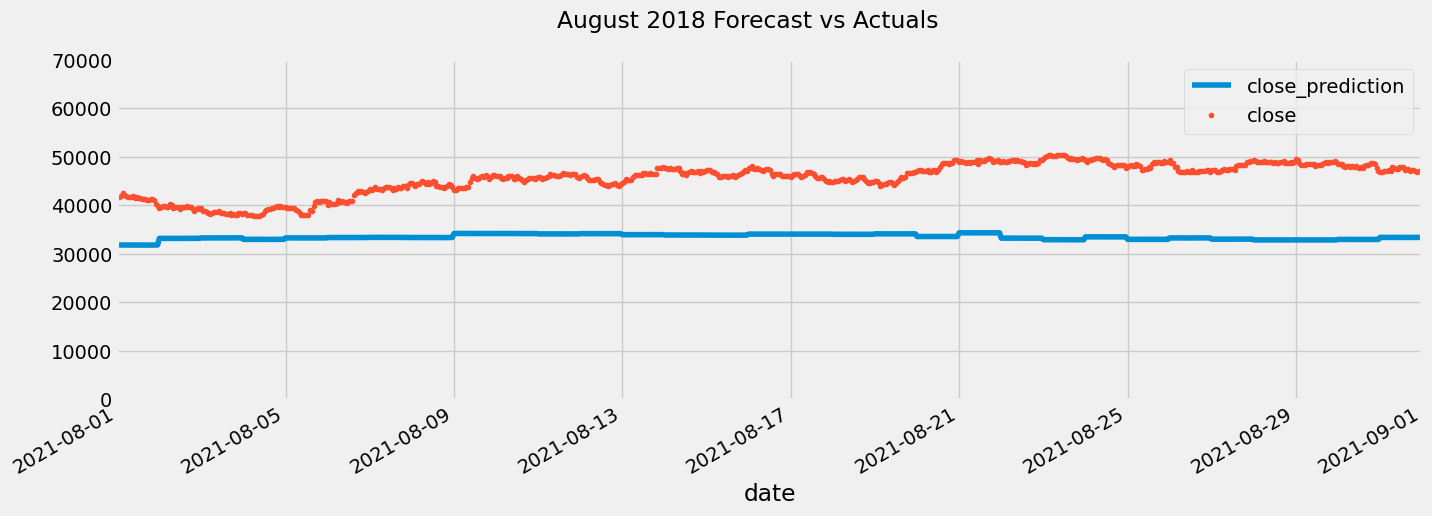

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['close_prediction','close']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2021', upper='09-01-2021')
ax.set_ylim(0, 70000)
plot = plt.suptitle('August 2018 Forecast vs Actuals')

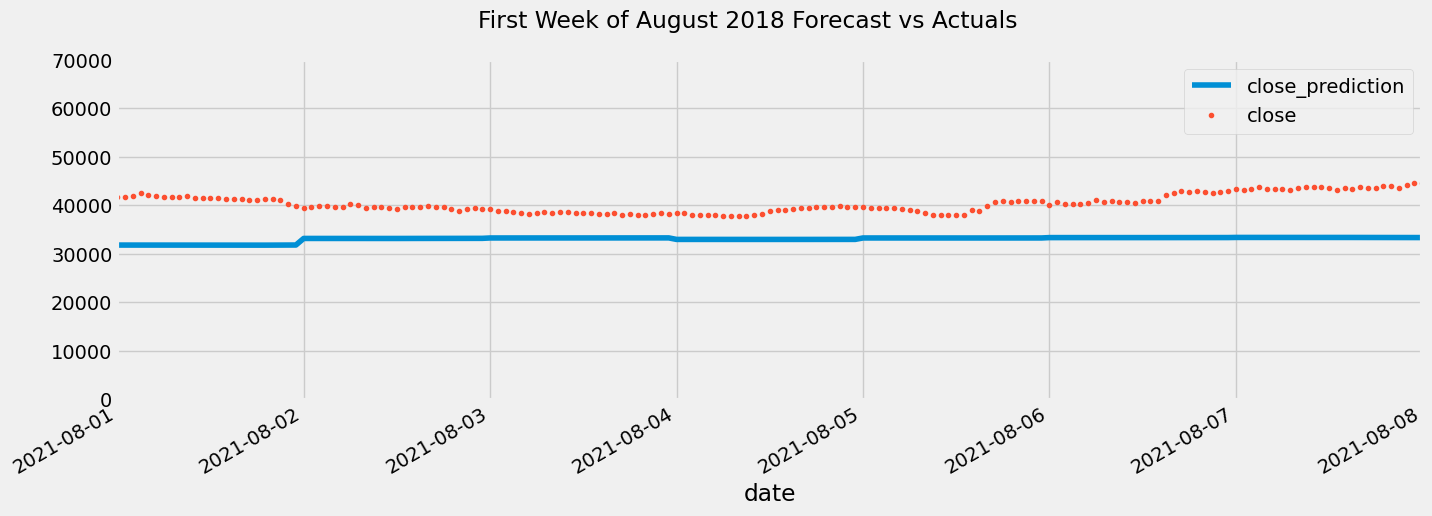

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['close_prediction','close']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2021', upper='08-08-2021')
ax.set_ylim(0, 70000)
plot = plt.suptitle('First Week of August 2018 Forecast vs Actuals')

Evaluation

In [ ]:
mean_squared_error(y_true=data_test['close'],
                   y_pred=data_test['close_prediction'])

302863083.1683471

In [ ]:
mean_absolute_error(y_true=data_test['close'],
                   y_pred=data_test['close_prediction'])

14489.618344778306

## 2 ARIMA (TODO: da sistemare)


Time Series forecasting using ARIMA

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data. This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
ARIMA is one of the mostly used techniques for Time Series analysis. In Python, ARIMA based forecasting models can be created either using AutoARIMA(Pyramid ARIMA) or StatsModel . Here we will be using StatsModel as Kaggle do not support Pyramid ARIMA till now.

In [ ]:
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product

In previous sections of LSTM,XGBoost and Prophet, we used hourly data to train the model. But here we will use the monthly data (for Seasonality).



In [ ]:
data['date'] = data['date'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='date', freq='M')]).first().reset_index()
data = data.set_index('date')
data = data[['close']]
data['close'].fillna(method='ffill', inplace=True)

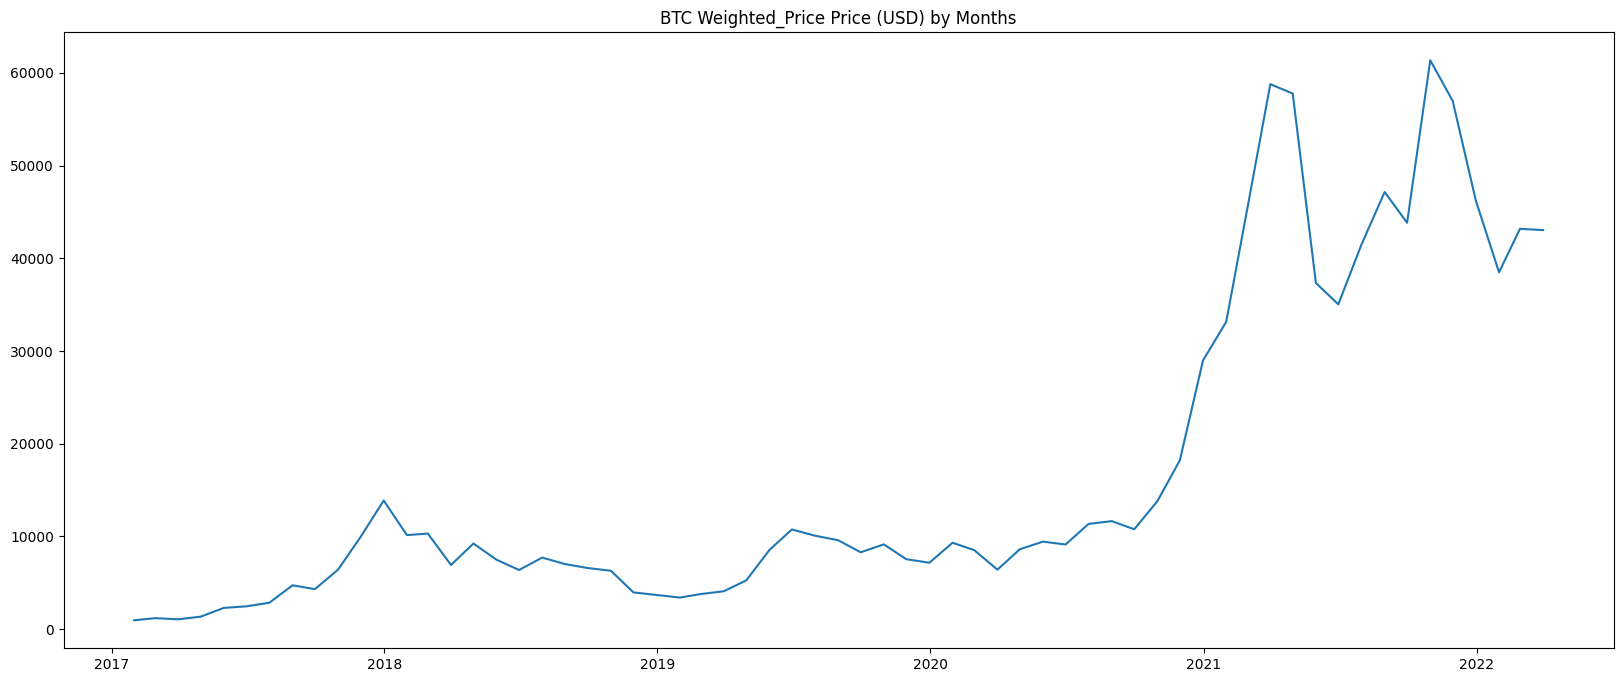

In [ ]:
plt.figure(figsize=[20,8])
plt.title('BTC Weighted_Price Price (USD) by Months')
plt.plot(data.close, '-', label='By Months')

Decomposition

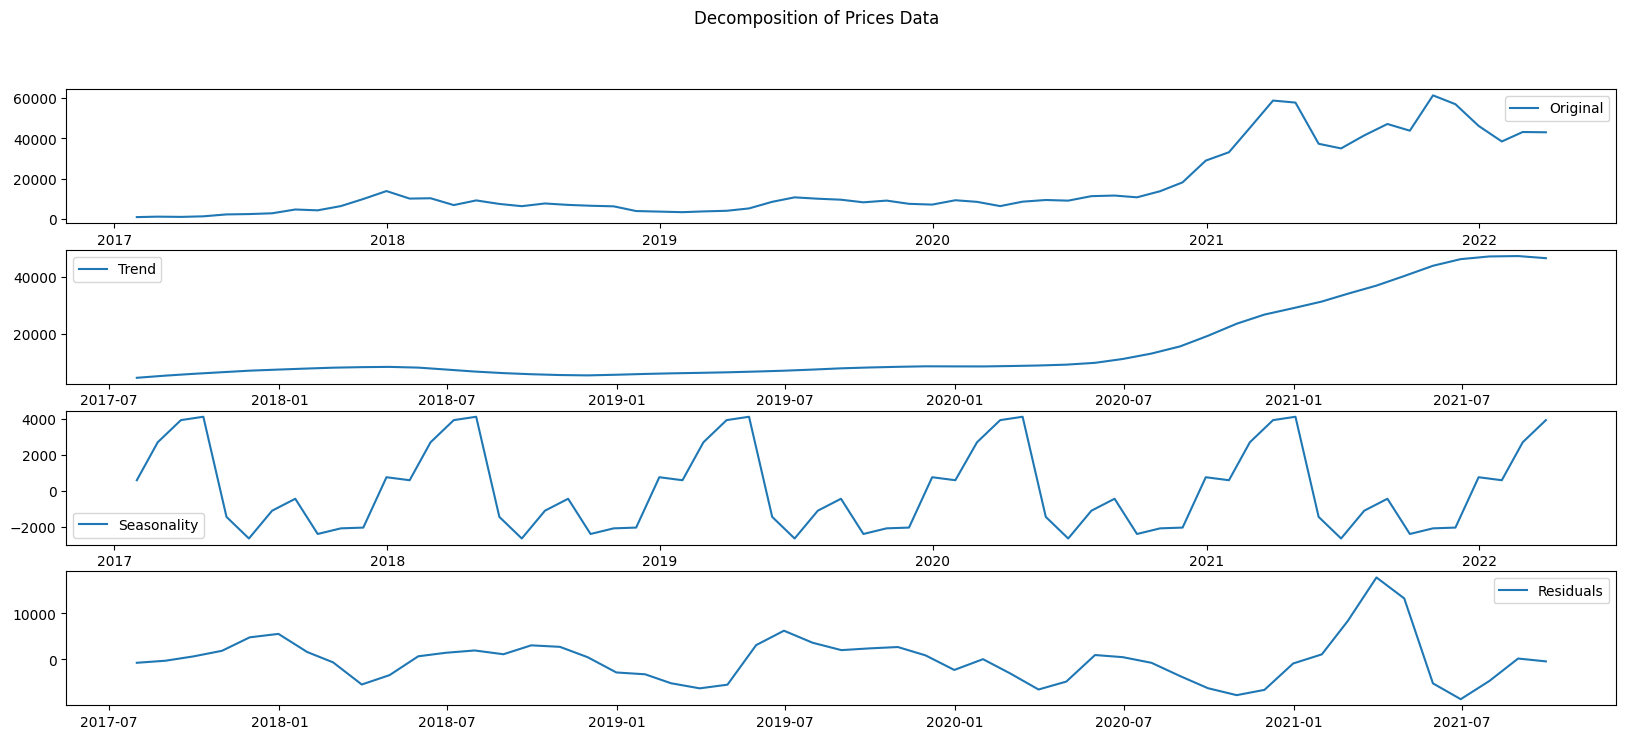

In [ ]:
decomposition = sm.tsa.seasonal_decompose(data.close)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(20,8))

plt.subplot(411)
plt.plot(data.close, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

fig.suptitle('Decomposition of Prices Data')
plt.show()

In [ ]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.close)[1])


Dickey–Fuller test: p=0.895978


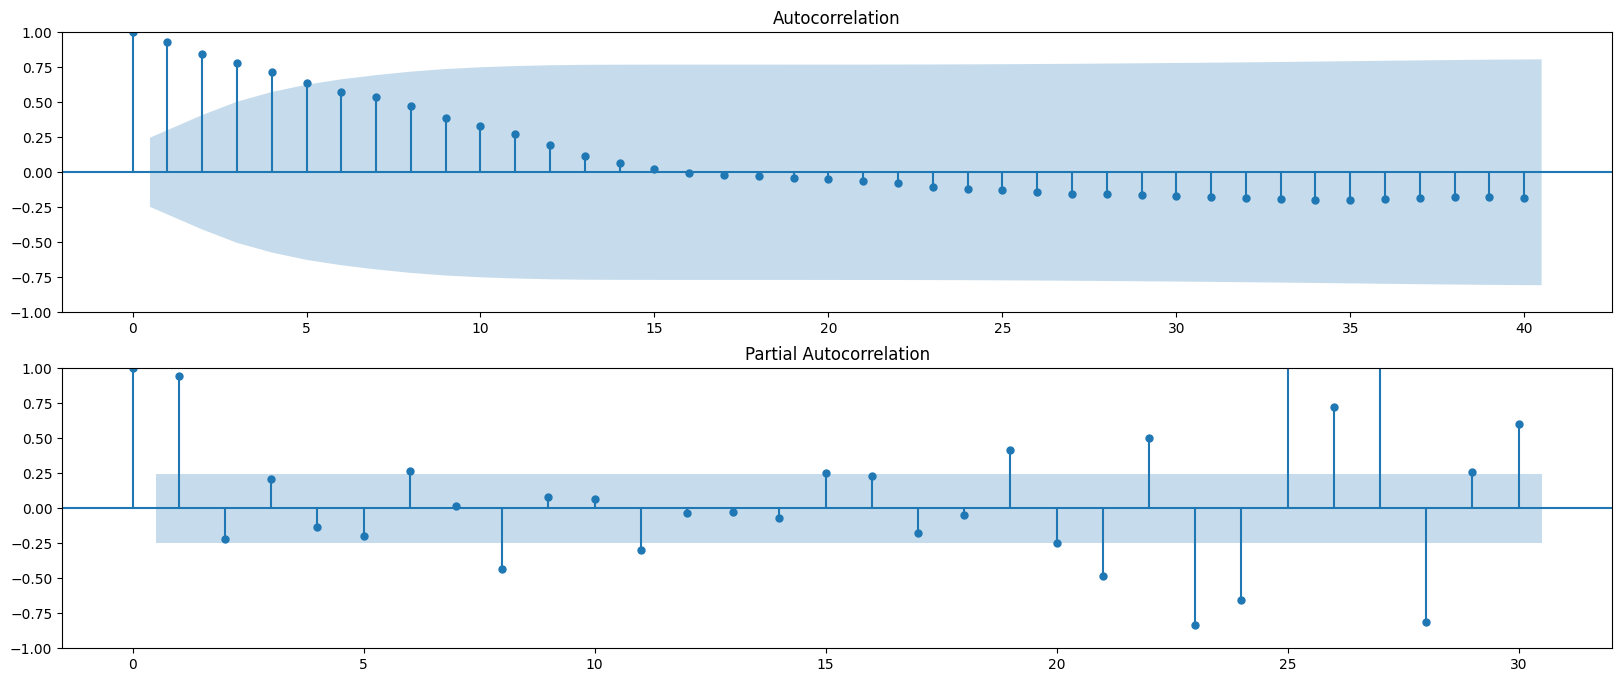

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(20,8))
pyplot.subplot(211)
plot_acf(data.close, ax=pyplot.gca(),lags=40)
pyplot.subplot(212)
plot_pacf(data.close, ax=pyplot.gca(), lags=30)
pyplot.show()

Here's the Statespace ARIMA Model, the best model is selected using different parameters.



In [ ]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.close, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12),enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=-1)
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])


In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
52  (2, 2, 2, 0)  503.964140
53  (2, 2, 2, 1)  504.664639
40  (2, 0, 2, 0)  505.456588
41  (2, 0, 2, 1)  506.774919
47  (2, 1, 2, 1)  508.597269
                                      SARIMAX Results                                      
Dep. Variable:                               close   No. Observations:                   63
Model:             SARIMAX(2, 1, 2)x(2, 1, [], 12)   Log Likelihood                -244.982
Date:                             Tue, 23 May 2023   AIC                            503.964
Time:                                     08:25:36   BIC                            512.211
Sample:                                 01-31-2017   HQIC                           506.152
                                      - 03-31-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

Dickey–Fuller test:: p=0.200338


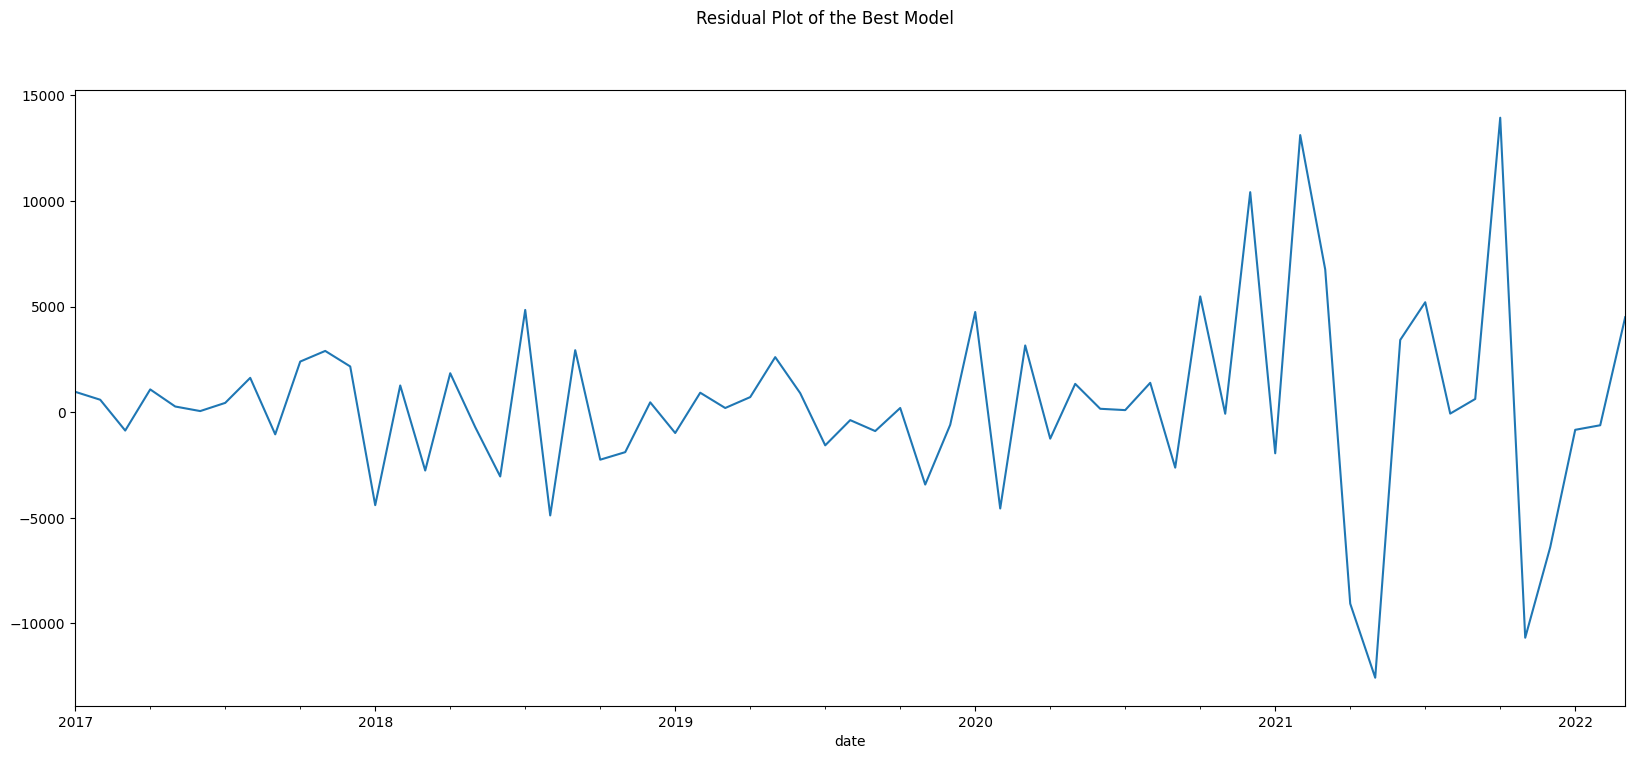

In [ ]:
fig = plt.figure(figsize=(20,8))
best_model.resid.plot()
fig.suptitle('Residual Plot of the Best Model')
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

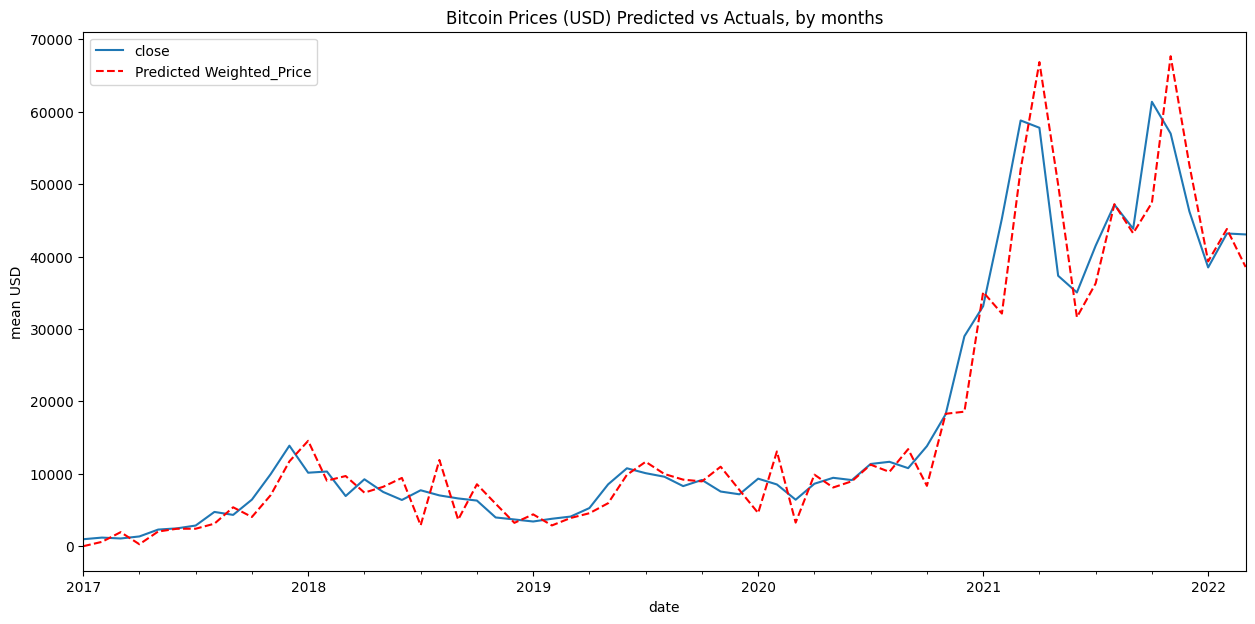

In [ ]:
df_month2 = data[['close']]
future = pd.DataFrame()
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=200)
plt.figure(figsize=(15,7))
df_month2.close.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('mean USD')
plt.show()


# 5. Conclusions (TODO: da sistemare)

Here lets visualize and compare the predictive results of LSTM, XGBoost and Prophet in a single plot,

[Text(0.5, 1.0, 'Recall score')]

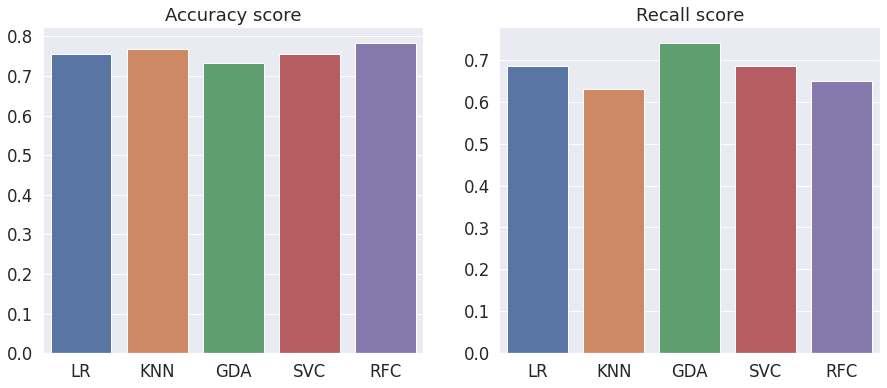

In [ ]:
# Create traces
trace0 = go.Scatter(
    x = final_data['Timestamp'],
    y = final_data['Weighted_Price'],
    mode = 'lines+markers',
    name = 'Real Price'
)
trace1 = go.Scatter(
    x = final_data['Timestamp'],
    y = final_data['lstm'],
    mode = 'lines+markers',
    name = 'LSTM Prediction'
)
trace2 = go.Scatter(
    x = final_data['Timestamp'],
    y = final_data['xgboost'],
    mode = 'lines+markers',
    name = 'XGBoost Prediction'
)
trace3 = go.Scatter(
    x = final_data['Timestamp'],
    y = final_data['prophet'],
    mode = 'lines+markers',
    name = 'Prophet Prediction'
)

# Edit the layout
layout = dict(title = 'Comparision of LSTM,XGBoost and Prophet',
              xaxis = dict(title = 'Month'),
              yaxis = dict(title = 'Prices (USD)'),
              )

data = [trace0, trace1, trace2, trace3]
fig = dict(data=data, layout=layout)
iplot(fig, filename='styled-line')


We can see how the above models perform with Historic Bitcoin Price data. The prediction is not good. The Bitcoin prices are very volatile and very random, and is often influenced by external factors (or news) such as Cryptocurrency regulations, Investments or simple rumours on social media. We need additional data from news or social media to make these models perform better and more accurately.